This code is an implementation of a **time series forecasting model using XGBoost**, a popular gradient boosting algorithm. The model is trained on a dataset of unit sales data for a number of unique items and stores, and the goal is to predict future unit sales for each unique item-store combination.

The code begins by reading in the dataset and performing some preprocessing steps, including adding a unique ID column, dropping irrelevant columns, and one-hot encoding the category column. It then splits the data into training and test sets for each unique item-store combination and performs cross-validation on the training data using a TimeSeriesSplit.

The XGBoost model is then trained on the training data for each unique item-store combination, and the model is used to make predictions for the next day's unit sales using a sliding window approach. The predictions are stored in a dataframe along with the actual values, and the results are plotted for each unique item-store combination.

Overall, the code implements a robust and flexible time series forecasting model that can be easily adapted to other datasets and forecasting problems.

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import xgboost as xgb

# Define the path to 'total.csv'
#total_csv_path = '/kaggle/input/total-final/total.csv'
total_csv_path = '/kaggle/input/total-with-category/total_with_category.csv'

# Load 'total.csv' and set index to 'date'
#data = pd.read_csv(total_csv_path, parse_dates=['date'], index_col='date')
data = pd.read_csv(total_csv_path)
data = data[data['store'] == 548]

# Add 'unique_id' column
#data['unique_id'] = data['item_nbr'].astype(str) + '_' + data['store'].astype(str)
data['unique_id'] = data['item_nbr'].astype(int) 

# Drop 'item_nbr' and 'store' columns
data.drop(['item_nbr', 'store'], axis=1, inplace=True)

# Select 10 random unique_ids and filter the data
random_unique_ids = random.sample(list(data['unique_id'].unique()), 5)
data = data[data['unique_id'].isin(random_unique_ids)]

#data = data.drop('index', axis=1)
# Sort the data by 'unique_id' and 'date'
data.sort_values(by=['unique_id', 'date'], inplace=True)

# Convert the date column to a datetime object and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
                        
# Assuming the data is already loaded into the DataFrame 'data'
data['category'] = data['category'].fillna('undefined')

# One-hot encoding for the 'category' column if there are more categories
data = pd.get_dummies(data, columns=['category'])

data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,unit_sales,bogo,circular_discount,circular,circedlp,coupon,discount_value,discount,fp_discount,front_page,fpedlp,gas,nopromo,unique_id,category_FROZEN,category_GROCERY,category_MEAT
date,,,,,,,,,,,,,,,,,
2021-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8345,1,0,0
2021-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8345,1,0,0
2021-01-25,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8345,1,0,0
2021-01-26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8345,1,0,0
2021-01-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8345,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,217888,1,0,0
2023-02-19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,217888,1,0,0
2023-02-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,217888,1,0,0


**Cross-validation** is a technique used to evaluate the performance of a machine learning model by training and testing it on different subsets of the data. In this case, the TimeSeriesSplit class is used to split the time series data into multiple folds to evaluate the model's performance over time.

In [2]:
train_ratio = 0.8

# Create a dictionary to store train and test data for each unique_id
train_test_data = {}

for i, unique_id in enumerate(random_unique_ids):
    unique_id_data = data[data['unique_id'] == unique_id]
    train_size = int(len(unique_id_data) * train_ratio)
    train = unique_id_data.iloc[:train_size]
    test = unique_id_data.iloc[train_size:]

    # Perform cross-validation on the train set
    train = train.sort_index()

    tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)

    # Create a list to store train and test folds for each unique_id
    train_test_folds = []
    for train_idx, val_idx in tss.split(train):
        train_fold = train.iloc[train_idx]
        test_fold = train.iloc[val_idx]
        train_test_folds.append((train_fold, test_fold))

    # Store train and test data in the dictionary
    train_test_data[unique_id] = {'train': train, 'test': test, 'folds': train_test_folds}


# Train

In [3]:
# Concatenate train sets from all unique_ids
all_train_data = pd.concat([train_test_data[unique_id]['train'] for unique_id in random_unique_ids])

all_train_data = all_train_data.sort_index()

# Create a TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(all_train_data):
    train_fold = all_train_data.iloc[train_idx]
    val_fold = all_train_data.iloc[val_idx]

    FEATURES = ['unique_id','bogo', 'circular_discount', 'circular', 'circedlp', 'coupon', 'discount_value', 'discount', 'fp_discount', 'front_page', 'fpedlp', 'gas', 'nopromo']
    TARGET = 'unit_sales'

    X_train = train_fold[FEATURES]
    y_train = train_fold[TARGET]

    X_val = val_fold[FEATURES]
    y_val = val_fold[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:4.14948	validation_1-rmse:4.40716
[100]	validation_0-rmse:2.88751	validation_1-rmse:3.04140
[200]	validation_0-rmse:2.66494	validation_1-rmse:2.74930
[300]	validation_0-rmse:2.63040	validation_1-rmse:2.69721
[400]	validation_0-rmse:2.62242	validation_1-rmse:2.68172
[500]	validation_0-rmse:2.61993	validation_1-rmse:2.68121
[503]	validation_0-rmse:2.61988	validation_1-rmse:2.68117
[0]	validation_0-rmse:4.15941	validation_1-rmse:4.89698
[100]	validation_0-rmse:2.88905	validation_1-rmse:3.35719
[200]	validation_0-rmse:2.66534	validation_1-rmse:2.95282
[300]	validation_0-rmse:2.63070	validation_1-rmse:2.85159
[400]	validation_0-rmse:2.62303	validation_1-rmse:2.84011
[500]	validation_0-rmse:2.62094	validation_1-rmse:2.83427
[600]	validation_0-rmse:2.61999	validation_1-rmse:2.83033
[700]	validation_0-rmse:2.61955	validation_1-rmse:2.82767
[769]	validation_0-rmse:2.61938	validation_1-rmse:2.82799
[0]	validation_0-rmse:4.18810	validation_1-rmse:5.08664
[100]	validation_0-r

In [4]:
print(f'Mean score across folds: {np.mean(scores):.4f}')
print(f'Fold scores: {scores}')

Mean score across folds: 2.7293
Fold scores: [2.680922172809759, 2.8274021472509925, 2.7204532959788335, 2.4778965662055388, 2.9397051984032085]


In [5]:
FEATURES = ['unique_id','bogo', 'circular_discount', 'circular', 'circedlp', 'coupon', 'discount_value', 'discount', 'fp_discount', 'front_page', 'fpedlp', 'gas', 'nopromo']
TARGET = 'unit_sales'

X_all = all_train_data[FEATURES]
y_all = all_train_data[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=20,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[0]	validation_0-rmse:4.24439
[100]	validation_0-rmse:2.90236
[200]	validation_0-rmse:2.66352
[300]	validation_0-rmse:2.62832
[400]	validation_0-rmse:2.62332
[499]	validation_0-rmse:2.62261


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Test

In [6]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Set the window size and horizon
window_size = 14
horizon = 1

# Define a function for each iteration
def make_prediction(unique_id, train_test_data, reg, FEATURES, TARGET, window_size):
    test_unique_id = train_test_data[unique_id]['test']
    preds = []

    # Iterate through the test set using the sliding window method
    for i in range(0, len(test_unique_id) - window_size - horizon + 1):
        # Select the window from the test set
        window = test_unique_id.iloc[i:i+window_size]

        # Prepare the features and target for the window
        X_window = window[FEATURES]
        y_window = window[TARGET]

        # Fit the model on the window
        reg.fit(X_window, y_window,
                eval_set=[(X_window, y_window)],
                verbose=100)

        # Make a prediction for the next day
        X_next_day = test_unique_id[FEATURES].iloc[i+window_size]
        y_next_day = test_unique_id[TARGET].iloc[i+window_size]
        y_pred = reg.predict(np.array(X_next_day).reshape(1, -1))

        preds.append({
            'unique_id': test_unique_id['unique_id'].iloc[i+window_size],
            'date': test_unique_id.index[i+window_size],
            'actuals': y_next_day,
            'predicted': y_pred[0]
        })

    return preds

# Use joblib and tqdm to parallelize and show the progress bar
predictions = Parallel(n_jobs=-1)(
    delayed(make_prediction)(unique_id, train_test_data, reg, FEATURES, TARGET, window_size)
    for unique_id in tqdm(random_unique_ids)
)

# Prepare an empty DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['unique_id', 'date', 'actuals', 'predicted'])

# Concatenate the results
for preds in predictions:
    predictions_df = pd.concat([predictions_df, pd.DataFrame(preds, columns=predictions_df.columns)], ignore_index=True)


 40%|████      | 2/5 [00:00<00:00, 15.83it/s]/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0]	validation_0-rmse:8.45251
[100]	validation_0-rmse:5.38962
[0]	validation_0-rmse:1.58568
[200]	validation_0-rmse:4.74858
[100]	validation_0-rmse:1.24918
[300]	validation_0-rmse:4.64250
[200]	validation_0-rmse:1.18921
[400]	validation_0-rmse:4.62602
[300]	validation_0-rmse:1.17975
[499]	validation_0-rmse:4.62350
[400]	validation_0-rmse:1.17829
[0]	validation_0-rmse:8.24414
[499]	validation_0-rmse:1.17807
[100]	validation_0-rmse:5.45002
[0]	validation_0-rmse:1.58655
[200]	validation_0-rmse:4.88235
[100]	validation_0-rmse:1.29852
[300]	validation_0-rmse:4.78939
[200]	validation_0-rmse:1.24851
[400]	validation_0-rmse:4.77498
[300]	validation_0-rmse:1.24066
[499]	validation_0-rmse:4.77278
[0]	validation_0-rmse:7.64131
[400]	validation_0-rmse:1.23946
[100]	validation_0-rmse:5.12830
[499]	validation_0-rmse:1.23927
[0]	validation_0-rmse:1.58735
[200]	validation_0-rmse:4.62389
[300]	validation_0-rmse:4.54162
[100]	validation_0-rmse:1.34283
[400]	validation_0-rmse:4.52888
[200]	validation_0-r

 40%|████      | 2/5 [00:19<00:00, 15.83it/s]

[300]	validation_0-rmse:3.75822
[100]	validation_0-rmse:1.66394
[400]	validation_0-rmse:3.73785
[200]	validation_0-rmse:1.63558
[499]	validation_0-rmse:3.73473
[300]	validation_0-rmse:1.63118
[0]	validation_0-rmse:8.59529
[400]	validation_0-rmse:1.63051
[100]	validation_0-rmse:5.03376
[499]	validation_0-rmse:1.63041
[200]	validation_0-rmse:4.23061
[0]	validation_0-rmse:1.83826
[300]	validation_0-rmse:4.09359
[100]	validation_0-rmse:1.66394
[400]	validation_0-rmse:4.07218
[200]	validation_0-rmse:1.63558
[499]	validation_0-rmse:4.06890
[300]	validation_0-rmse:1.63118
[0]	validation_0-rmse:8.56316
[400]	validation_0-rmse:1.63051
[100]	validation_0-rmse:5.06859
[499]	validation_0-rmse:1.63041
[200]	validation_0-rmse:4.28816
[0]	validation_0-rmse:1.80014
[300]	validation_0-rmse:4.15560
[100]	validation_0-rmse:1.67826
[400]	validation_0-rmse:4.13490
[200]	validation_0-rmse:1.65878
[499]	validation_0-rmse:4.13173
[300]	validation_0-rmse:1.65578
[0]	validation_0-rmse:7.70678
[400]	validation_0

100%|██████████| 5/5 [00:34<00:00,  6.81s/it]


[0]	validation_0-rmse:2.01723
[100]	validation_0-rmse:1.54057
[200]	validation_0-rmse:1.45375
[0]	validation_0-rmse:0.72959
[300]	validation_0-rmse:1.43998
[100]	validation_0-rmse:0.61618
[400]	validation_0-rmse:1.43786
[200]	validation_0-rmse:0.59689
[499]	validation_0-rmse:1.43753
[300]	validation_0-rmse:0.59388
[400]	validation_0-rmse:0.59341
[499]	validation_0-rmse:0.59334
[0]	validation_0-rmse:0.97806
[0]	validation_0-rmse:1.44951
[100]	validation_0-rmse:0.78307
[100]	validation_0-rmse:1.35268
[200]	validation_0-rmse:0.74870
[200]	validation_0-rmse:1.33721
[300]	validation_0-rmse:0.74329
[300]	validation_0-rmse:1.33483
[400]	validation_0-rmse:0.74246
[400]	validation_0-rmse:1.33446
[499]	validation_0-rmse:0.74233
[499]	validation_0-rmse:1.33441
[0]	validation_0-rmse:0.97806
[0]	validation_0-rmse:1.29428
[100]	validation_0-rmse:0.78307
[100]	validation_0-rmse:1.23391
[200]	validation_0-rmse:0.74870
[200]	validation_0-rmse:1.22439
[300]	validation_0-rmse:0.74329
[300]	validation_0-r

In [7]:
# Display the predictions DataFrame
predictions_df['predicted'] = np.round(predictions_df['predicted'])
predictions_df

,unique_id,date,actuals,predicted
0,87405,2022-10-07,3.0,8.0
1,87405,2022-10-08,5.0,7.0
2,87405,2022-10-09,13.0,7.0
3,87405,2022-10-10,21.0,7.0
4,87405,2022-10-11,5.0,8.0
...,...,...,...,...
690,27293,2023-02-18,3.0,1.0
691,27293,2023-02-19,0.0,1.0
692,27293,2023-02-20,2.0,1.0
693,27293,2023-02-21,0.0,1.0


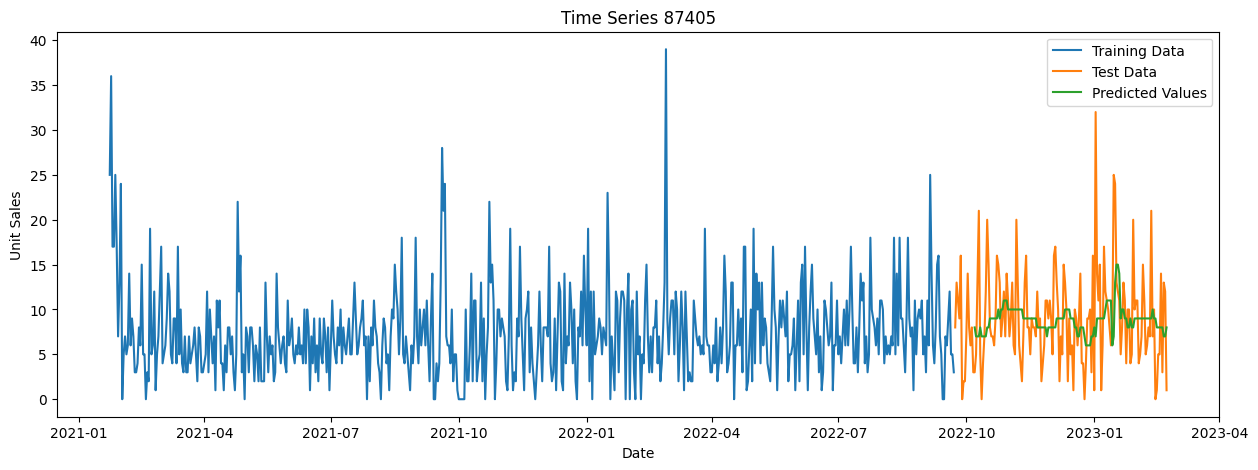

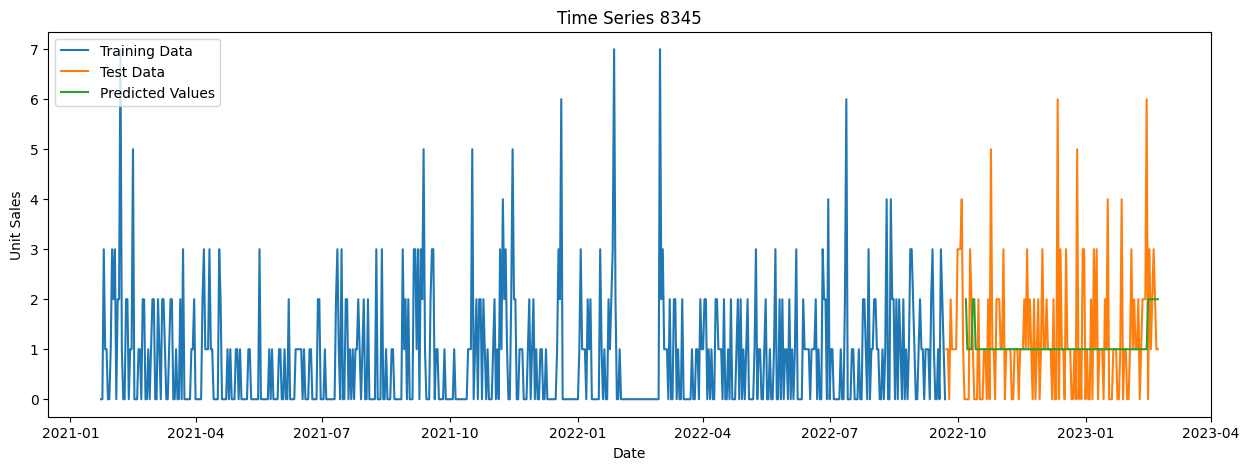

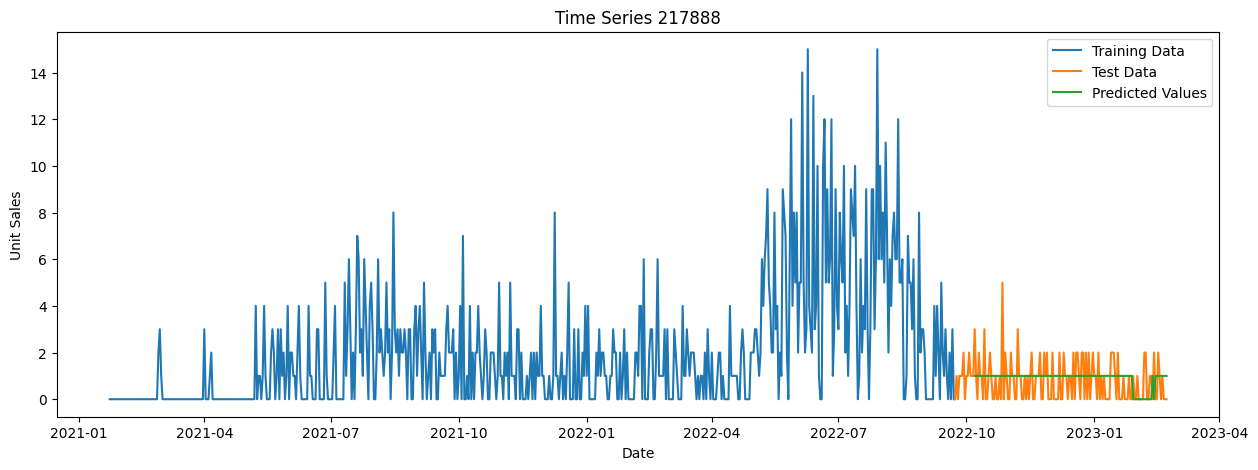

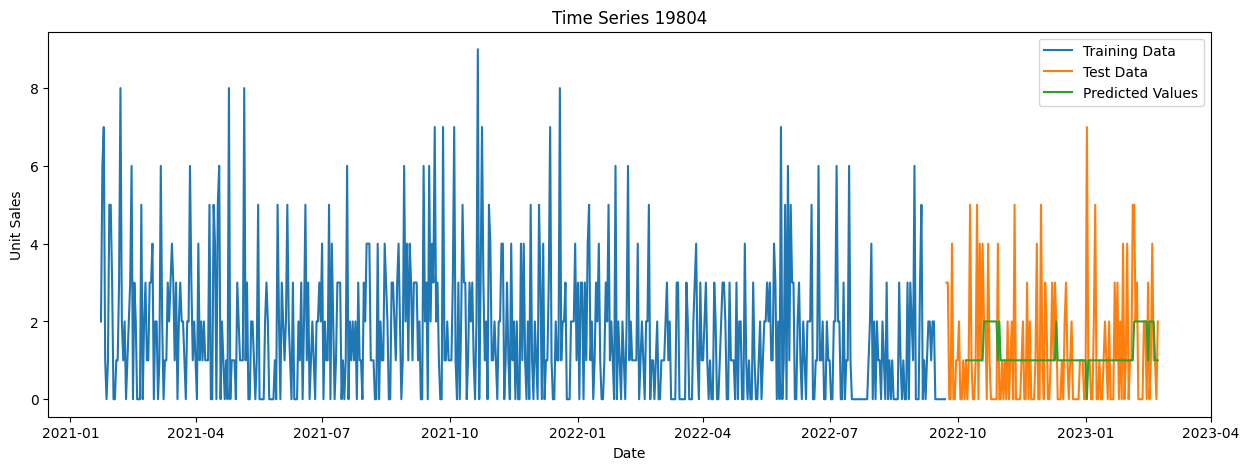

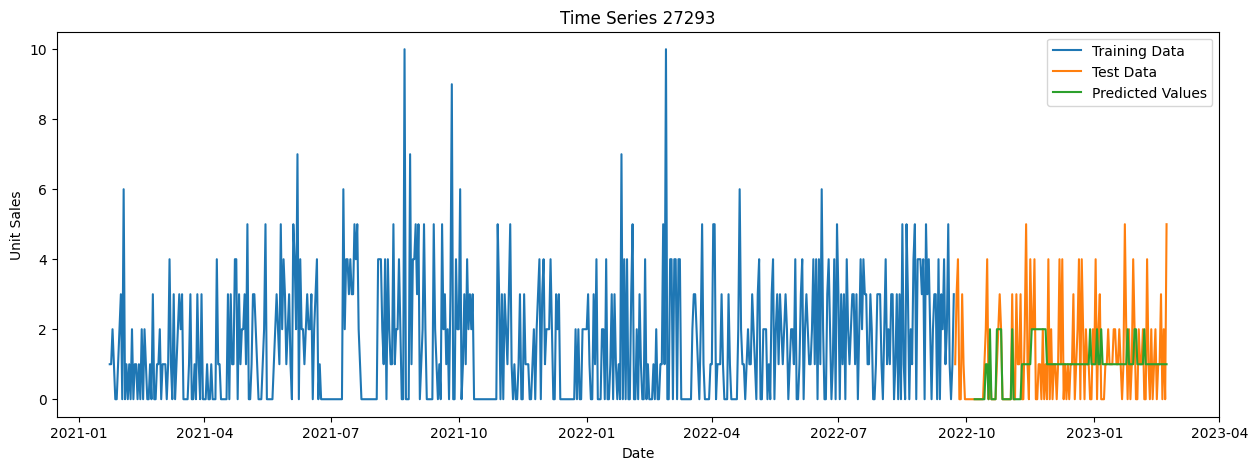

In [8]:
import matplotlib.pyplot as plt

# Loop through each unique_id in the test set
for unique_id in random_unique_ids:
    # Filter the data for the current unique_id
    train_filtered = train_test_data[unique_id]['train']
    test_filtered = train_test_data[unique_id]['test']
    results_filtered = predictions_df[predictions_df['unique_id'] == unique_id]

    # Extract the unit sales values for the current unique_id
    Y_train_filtered = train_filtered[TARGET].values
    Y_test_filtered = test_filtered[TARGET].values

    # Get the predicted values directly from the 'results_filtered' DataFrame
    Y_pred_filtered = results_filtered['predicted'].values

    # Plot the training data, test data, and predicted values for the current unique_id
    plt.figure(figsize=(15, 5))
    plt.plot(train_filtered.index[-len(Y_train_filtered):], Y_train_filtered, label='Training Data')
    plt.plot(test_filtered.index[:len(Y_test_filtered)], Y_test_filtered, label='Test Data')
    plt.plot(results_filtered['date'][:len(Y_pred_filtered)], Y_pred_filtered, label='Predicted Values')
    plt.title(f"Time Series {unique_id}")
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()

# Evaluation Metrics

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_scaled_error(actuals, predicted, seasonality=1):
    mae = np.mean(np.abs(actuals - predicted))
    naive_mae = np.mean(np.abs(actuals[seasonality:] - actuals[:-seasonality]))
    return mae / naive_mae

results = []

# Loop through each unique_id in the predictions_df
for unique_id in random_unique_ids:
    unique_id_predictions = predictions_df[predictions_df['unique_id'] == unique_id]
    actuals = unique_id_predictions['actuals'].values
    predicted = unique_id_predictions['predicted'].values

    # Calculate the error metrics
    mae = mean_absolute_error(actuals, predicted)
    rmse = np.sqrt(mean_squared_error(actuals, predicted))
    mase = mean_absolute_scaled_error(actuals, predicted)

    results.append({'unique_id': unique_id,
                    'MAE': mae,
                    'RMSE': rmse,
                    'MASE': mase})

# Save the results in a new DataFrame
results_df = pd.DataFrame(results)

results_df.to_csv('metrics_xgboost.csv', index=False)

results_df


,unique_id,MAE,RMSE,MASE
0,87405,4.158273,5.435032,0.824485
1,8345,0.856115,1.266616,0.645595
2,217888,0.762590,0.967084,0.746365
3,19804,1.187050,1.624896,0.709147
4,27293,0.935252,1.383354,0.635787


In [10]:
import plotly.graph_objs as go

# Create a box plot for MAE
trace1 = go.Box(
    y=results_df['MAE'],
    name="MAE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for RMSE
trace2 = go.Box(
    y=results_df['RMSE'],
    name="RMSE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for MASE
trace3 = go.Box(
    y=results_df['MASE'],
    name="MASE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a layout for the box plots
layout = go.Layout(
    title="Evaluation Metrics Box Plots",
    yaxis=dict(title="Value"),
    boxmode='group'
)

# Combine the traces and layout into a single figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Plot the figure
fig.show()

# Interpretability

# Built-in Interpretability


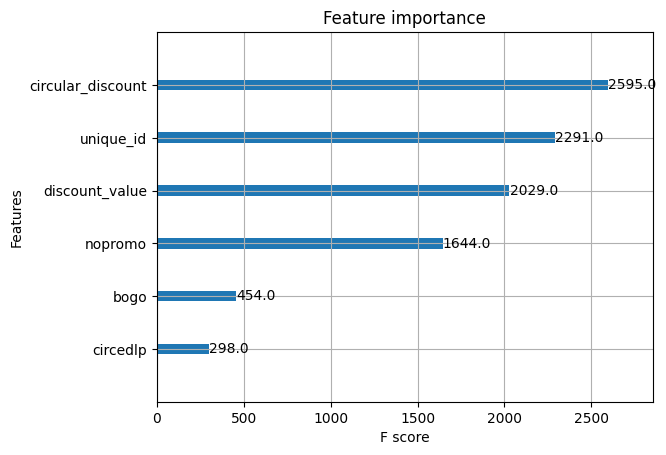

In [11]:
xgb.plot_importance(reg)
plt.show()

# SHAP


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


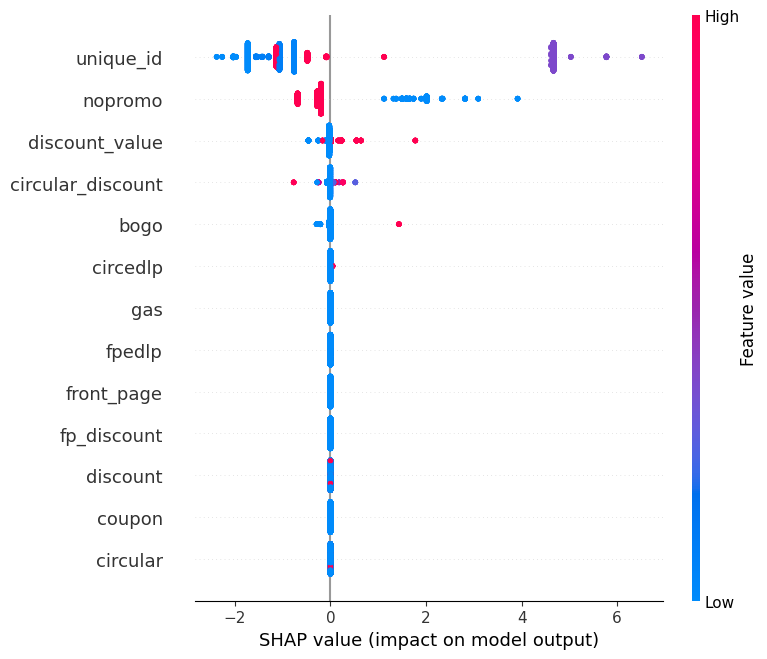

In [12]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

# Create a TreeExplainer object
explainer = shap.TreeExplainer(reg)

# Calculate SHAP values
shap_values = explainer.shap_values(X_all)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_all)

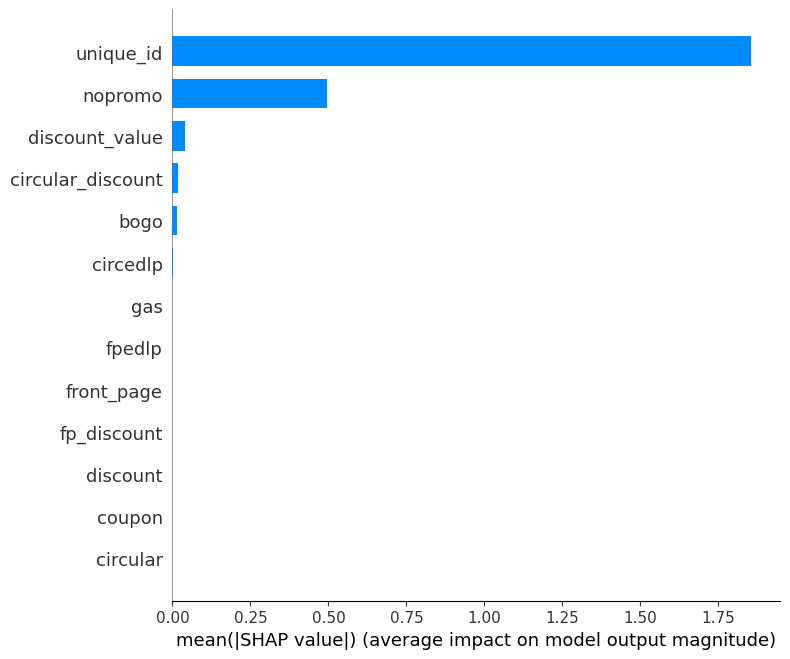

In [13]:
# Calculate SHAP values for the validation data
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_all)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_all, plot_type="bar")